# GCN, GAT model supervised on graphs from train TSPs and targeted valid inequalities

In [ ]:
!pip install dgl

     |████████████████████████████████| 3.0MB 2.8MB/s 


In [ ]:
!pip install pulp

     |████████████████████████████████| 40.6MB 102kB/s 


In [ ]:
!pip install nodevectors

In [ ]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.data.utils import save_graphs
from dgl.data.utils import load_graphs
import torch.optim as optim
import numpy as np
import pandas as pd 
import random 
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt 
import networkx as nx 

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from google.colab import files

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# mijn functions
import actions_v12 as act
import graph_models_v17 as gm

**Load train graphs and labels**

In [ ]:
l1 = pd.read_csv("TRAIN_LABELS1.csv")
l2 = pd.read_csv("TRAIN_LABELS2.csv")
l3 = pd.read_csv("TRAIN_LABELS3.csv")
labels = l1.append(l2).append(l3).reset_index(drop=True)

len(labels)

2515

In [ ]:
g1 = load_graphs("train_graphs1.bin")
g2 = load_graphs("train_graphs2.bin")
g3 = load_graphs("train_graphs3.bin")
graphs = g1[0] + g2[0] + g3[0]

labels_keep = labels
labels = labels.iloc[:, 1:10] # ignore the last class (none)

len(graphs)

2515

In [ ]:
labels.head()

,0,1,2,3,4,5,6,7,8
0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.0
1,6.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
2,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Make targets binary**

In [ ]:
labels['0'] = np.where(labels['0']>0, 1.0, 0.0)
labels['1'] = np.where(labels['1']>0, 1.0, 0.0)
labels['2'] = np.where(labels['2']>0, 1.0, 0.0)
labels['3'] = np.where(labels['3']>0, 1.0, 0.0)
labels['4'] = np.where(labels['4']>0, 1.0, 0.0)
labels['5'] = np.where(labels['5']>0, 1.0, 0.0)
labels['6'] = np.where(labels['6']>0, 1.0, 0.0)
labels['7'] = np.where(labels['7']>0, 1.0, 0.0)
labels['8'] = np.where(labels['8']>0, 1.0, 0.0)

labels_keep['0'] = np.where(labels_keep['0']>0, 1.0, 0.0)
labels_keep['1'] = np.where(labels_keep['1']>0, 1.0, 0.0)
labels_keep['2'] = np.where(labels_keep['2']>0, 1.0, 0.0)
labels_keep['3'] = np.where(labels_keep['3']>0, 1.0, 0.0)
labels_keep['4'] = np.where(labels_keep['4']>0, 1.0, 0.0)
labels_keep['5'] = np.where(labels_keep['5']>0, 1.0, 0.0)
labels_keep['6'] = np.where(labels_keep['6']>0, 1.0, 0.0)
labels_keep['7'] = np.where(labels_keep['7']>0, 1.0, 0.0)
labels_keep['8'] = np.where(labels_keep['8']>0, 1.0, 0.0)
labels_keep = labels_keep.drop(['6', 'Unnamed: 0'], axis=1)
labels.head()

,0,1,2,3,4,5,6,7,8
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Load random graphs from previous train graphs**

In [ ]:
l1 = pd.read_csv("TRAIN_LABELS11.csv")
l2 = pd.read_csv("TRAIN_LABELS22.csv")
labels2 = l1.append(l2).reset_index(drop=True)

labels2["rank"] = labels2.groupby("tsp_id")["Unnamed: 0"].rank("dense", ascending=True)
labels2 = labels2[labels2["rank"] <= 3] # take only first three graphs per tsp

# take only random graphs 
labels2 = labels2[labels2['tsp_id'] < 3000]
labels2 = labels2[(labels2['tsp_id'] < 1000) | (labels2['tsp_id'] >= 2000)]

len(labels2)

351

In [ ]:
g1 = load_graphs("train_graphs11.bin")
g2 = load_graphs("train_graphs22.bin")
graphs2 = g1[0] + g2[0]

graphs1 = []
for k in list(labels2["Unnamed: 0"]):
  graphs1.append(graphs2[k])

graphs2 = graphs1
labels2 = labels2.iloc[:, 1:10] # ignore the last class (none)

len(graphs2)

351

In [ ]:
labels2['0'] = np.where(labels2['0']>0, 1.0, 0.0)
labels2['1'] = np.where(labels2['1']>0, 1.0, 0.0)
labels2['2'] = np.where(labels2['2']>0, 1.0, 0.0)
labels2['3'] = np.where(labels2['3']>0, 1.0, 0.0)
labels2['4'] = np.where(labels2['4']>0, 1.0, 0.0)
labels2['5'] = np.where(labels2['5']>0, 1.0, 0.0)
labels2['6'] = np.where(labels2['6']>0, 1.0, 0.0)
labels2['7'] = np.where(labels2['7']>0, 1.0, 0.0)
labels2['8'] = np.where(labels2['8']>0, 1.0, 0.0)
labels2.head()

,0,1,2,3,4,5,6,7,8
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0


**Balance weights**

In [ ]:
# 0: subtour elimination
# 1: blossoms (basic combs)
# 2: advanced comb
# 3: clique tree
# 4: blossom + path 
# 5: bipartition
# 6: envelope
# 7: crown 8 
# 8: crown multiple 
# 9: none working, branching needed 

# Initial distributions
class1 = round(labels.sum()/len(labels)*100, 1)
print(class1)

labels = labels.append(labels2).reset_index(drop=True)
graphs = graphs + graphs2
print('**********************************')
print('length comparison:', len(labels), len(graphs))
print('**********************************')
class1 = round(labels.sum()/len(labels)*100, 1)
print(class1)

0    47.9
1    74.2
2    34.4
3    26.0
4    59.4
5     7.6
6     0.7
7    31.5
8    23.6
dtype: float64
**********************************
length comparison: 2866 2866
**********************************
0    52.3
1    73.5
2    32.8
3    26.9
4    60.2
5     7.4
6     0.7
7    32.8
8    23.5
dtype: float64


In [ ]:
# Ignored envelopes due to lack of target=1 and Crowns
labels = labels.drop(['6'], axis=1)
labels.head()

,0,1,2,3,4,5,7,8
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# class 1 (and 4) has fewer 0s, tried to balance them
# oversample class of blossoms target=0
add_label_1 = []
add_g_1 = []

for k in range(len(labels)):
  if labels.iloc[k][1] == 0: 
    add_label_1.append(labels.iloc[k])
    add_g_1.append(graphs[k])

In [ ]:
len(add_label_1)

760

In [ ]:
labels = labels.append(add_label_1).reset_index(drop=True)
len(labels)

3626

In [ ]:
graphs = graphs + add_g_1
len(graphs)

3626

In [ ]:
# check target distributions again 
class1 = round(labels.sum()/len(labels)*100, 1)
class1

0    54.8
1    58.1
2    27.3
3    21.5
4    48.0
5     6.0
7    31.4
8    21.3
dtype: float64

In [ ]:
# oversample class of bipartitions target=1
add_label_5 = []
add_g_5 = []

for k in range(len(labels)):
  if labels.iloc[k][5] == 1: 
    add_label_5.append(labels.iloc[k])
    add_g_5.append(graphs[k])

In [ ]:
len(add_label_5)

216

In [ ]:
labels = labels.append(add_label_5).append(add_label_5).append(add_label_5).reset_index(drop=True)
len(labels)

4274

In [ ]:
graphs = graphs + add_g_5 + add_g_5 + add_g_5
len(graphs)

4274

In [ ]:
# check target distributions again 
class1 = round(labels.sum()/len(labels)*100, 1)
class1

0    53.6
1    63.7
2    31.9
3    23.8
4    52.9
5    20.2
7    32.1
8    23.7
dtype: float64


*   Increases in 2 and 5 cause increase in 1 too, so I stopped oversampling and added weights for imbalanced classes.



In [ ]:
# class distributions of 1s and 0s (100%)
class1 = round(labels.sum()/len(labels)*100, 1)
class0 = 100 - class1

weights = []
for k in range(len(class1)):
  if class1.iloc[k] > class0.iloc[k]:
    w_ = class1.iloc[k]/class0.iloc[k]
  else: 
    w_ = class0.iloc[k]/class1.iloc[k]
  
  weights.append(w_)

weights = np.round(weights, 1)


# Inequalities 1, 3 and 4 are correlated so that I set target 1 and 4 as 1 and 1.5 for subtour elimination
weights[0] = 1.5
weights[1] = 1.0
weights

array([1.5, 1. , 2.1, 3.2, 1.1, 4. , 2.1, 3.2])

In [ ]:
class1 = round(labels.sum()/len(labels)*100, 1)
class1

0    53.6
1    63.7
2    31.9
3    23.8
4    52.9
5    20.2
7    32.1
8    23.7
dtype: float64

In [ ]:
# change column names for convenience 
labels = labels.rename(columns={'7':'6', '8':'7'})
labels.head()

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Train/save the model**

In [ ]:
def train_model(model, loss_func, optimizer, train_states, epochs, batch_size1, weights, MODEL_TAG):
  print("start time:", datetime.now())
  epoch_losses = []
  data_loader = DataLoader(train_states, batch_size=batch_size1, shuffle=True, collate_fn=gm.collect_graphs)
  model.train()

  for epoch in range(epochs):
    
    epoch_loss = 0 
    for iter, (graph, label) in enumerate(data_loader):
      
      prediction, graph_emb, node_emb = model(graph)
      loss = loss_func(prediction, label)
      loss = (loss * weights).mean()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.detach().item()
      epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

  plt.title('Epoch losses')
  plt.plot(epoch_losses)
  plt.show()

  #save model
  #th.save(model.state_dict(), MODEL_TAG+".pth.tar")
  #files.download(MODEL_TAG+".pth.tar") 
  print("end time:", datetime.now())
  return model

**Relu x N -> Sigmoid**

In [ ]:
GCN1 = gm.GCN5_MN(4, 256, len(weights), 0.2) # 5 conv layers
#GCN2 = gm.GCN5_MX(4, 256, len(weights), 0.2) # 5 conv layers
#GCN3 = gm.GCN5_SU(4, 256, len(weights), 0.2) # 5 conv layers

#GAT1 = gm.GAT3_MN(4, 16, 8, len(weights), 0.2) # 3 att layers
#GAT2 = gm.GAT3_MX(4, 16, 8, len(weights), 0.2) # 3 att layers
#GAT3 = gm.GAT3_SU(4, 16, 8, len(weights), 0.2) # 3 att layers

#optimizer11 = optim.Adam(GCN1.parameters(), lr=0.001)
#optimizer12 = optim.Adam(GCN2.parameters(), lr=0.001)
#optimizer13 = optim.Adam(GCN3.parameters(), lr=0.001)
#optimizer21 = optim.Adam(GAT1.parameters(), lr=0.001)
#optimizer22 = optim.Adam(GAT2.parameters(), lr=0.001)
#optimizer23 = optim.Adam(GAT3.parameters(), lr=0.001)

#weights_ = th.FloatTensor(weights)

#epochs1 = 300
#epochs2 = 200
#batch_size1 = 64
#loss_func = nn.BCELoss(reduction='none')

**Other variations**

In [ ]:
GCN11 = gm.GCN5_MN_NEG(8, 256, len(weights), 0.2) 
#GCN22 = gm.GCN5_MN_COORD(4, 256, len(weights), 0.2)
GAT11 = gm.GAT3_MN_NEG(8, 16, 8, len(weights), 0.2) 
#GAT22 = gm.GAT3_MN_COORD(4, 16, 8, len(weights), 0.2) 

optimizer111 = optim.Adam(GCN11.parameters(), lr=0.001)
#optimizer222 = optim.Adam(GCN22.parameters(), lr=0.001)
optimizer333 = optim.Adam(GAT11.parameters(), lr=0.001)
#optimizer444 = optim.Adam(GAT22.parameters(), lr=0.001)

weights_ = th.FloatTensor(weights)

epochs1 = 300
epochs2 = 200
batch_size1 = 64
loss_func = nn.BCELoss(reduction='none')

**TANH and Sigmoid instead of Relu -> Sigmoid on top**

In [ ]:
#GCN11 = gm.GCN5_MN_NEG(4, 256, len(weights), 0.2) # 5 conv layers and tanh act func
#GCN22 = gm.GAT5_MN_SIG(4, 256, len(weights), 0.2) # 5 conv layers and sigmoid act func

#optimizer111 = optim.Adam(GCN11.parameters(), lr=0.001)
#optimizer222 = optim.Adam(GCN22.parameters(), lr=0.001)

#weights_ = th.FloatTensor(weights)

#epochs1 = 300
#epochs2 = 200
#batch_size1 = 64
#loss_func = nn.BCELoss(reduction='none')

In [ ]:
# load if there are already trained models
#print('loading weights')
GCN1.load_state_dict(th.load("GCN1_JUN3.pth.tar"))
#GCN2.load_state_dict(th.load("GCN2_JUN3.pth.tar"))
#GCN3.load_state_dict(th.load("GCN3_JUN3.pth.tar"))

#GAT1.load_state_dict(th.load("GAT1_JUN4.pth.tar"))
#GAT2.load_state_dict(th.load("GAT2_JUN4.pth.tar"))
#GAT3.load_state_dict(th.load("GAT3_JUN4.pth.tar"))

<All keys matched successfully>

In [ ]:
#GCN11.load_state_dict(th.load("GCN_TANH_JUN11.pth.tar"))
#GCN22.load_state_dict(th.load("GCN_SIG_JUN11.pth.tar"))

<All keys matched successfully>

In [ ]:
#GCN11.load_state_dict(th.load("GCN_NEG_JUN15.pth.tar"))
#GAT11.load_state_dict(th.load("GAT_NEG_JUN15.pth.tar"))

<All keys matched successfully>

**Continue w training**

In [ ]:
train_states = [] 
for k in range(len(graphs)): 
  train_states.append([graphs[k], list(labels.iloc[k])])

In [ ]:
print('training models')
#train_model(GCN1, loss_func, optimizer11, train_states, epochs1, batch_size1, weights_, "GCN1_JUN3")
#train_model(GCN2, loss_func, optimizer12, train_states, epochs1, batch_size1, weights_, "GCN2_JUN3")
#train_model(GCN3, loss_func, optimizer13, train_states, epochs1, batch_size1, weights_, "GCN3_JUN3")
#train_model(GAT1, loss_func, optimizer21, train_states, epochs2, batch_size1, weights_, "GAT1_JUN4")
#train_model(GAT2, loss_func, optimizer22, train_states, epochs2, batch_size1, weights_, "GAT2_JUN4")
#train_model(GAT3, loss_func, optimizer23, train_states, epochs2, batch_size1, weights_, "GAT3_JUN4")

training models


In [ ]:
print('training models 2')
#train_model(GCN11, loss_func, optimizer111, train_states, epochs1, batch_size1, weights_, "GCN_TANH_JUN11")
#train_model(GCN22, loss_func, optimizer222, train_states, epochs1, batch_size1, weights_, "GCN_SIG_JUN11")

training models 2


In [ ]:
print('training models 3')
#train_model(GCN11, loss_func, optimizer111, train_states, epochs1, batch_size1, weights_, "GCN_NEG_JUN15")
#train_model(GAT11, loss_func, optimizer333, train_states, epochs1, batch_size1, weights_, "GAT_NEG_JUN15")

training models 3


In [ ]:
#th.save(GAT11.state_dict(), "GAT_NEG_JUN15.pth.tar")
#files.download("GAT_NEG_JUN15.pth.tar")

# Evaluation Time

In [ ]:
GCN1.eval()
GCN2.eval()
GCN3.eval()
GAT1.eval()
GAT2.eval()
GAT3.eval()

NameError: ignored

In [ ]:
GCN11.eval()
#GCN22.eval()
GAT11.eval()

GAT3_MN_NEG(
  (gat1): GATLayer(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc): Linear(in_features=8, out_features=128, bias=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (gat2): GATLayer(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc): Linear(in_features=128, out_features=128, bias=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (gat3): GATLayer(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc): Linear(in_features=128, out_features=128, bias=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (drop_layer1): Dropout(p=0.2, inplace=False)
  (classify): Linear(in_features=128, out_features=8, bias=True)
)

**Case check**

In [ ]:
#%% Selected cases
tsp_list = [
  (55,'uniform',3, 'TrainTSP0_3.csv'),
  (64,'normal',54, 'TrainTSP1_4.csv'),
  (55,'exponential',103, 'TrainTSP2_3.csv'),
  (73,'balanced_tree',159, 'TrainTSP3_9.csv'),
  (59,'barbell',201, 'TrainTSP4_3.csv'),
  (69,'complete_multipartite',249, 'TrainTSP5_1.csv'),
  (46,'circular_ladder',300, 'TrainTSP6_2.csv'),
  (42,'ladder',348, 'TrainTSP7_0.csv'),
  (50,'star',398, 'TrainTSP8_0.csv'),
  (63,'cavemen',448, 'TrainTSP9_0.csv'),
  (39,'lollipop',549, 'TrainTSP11_1.csv'),
  (54,'grid',600, 'TrainTSP12_4.csv'),
  (64,'ring_of_cliques',797, 'TrainTSP16_2.csv')
]

Distribution: uniform
Number of nodes: 55
Labels: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Model prediction: [[0.61 0.05 0.03 0.   0.05 0.   0.49 0.17]]
Status: Optimal


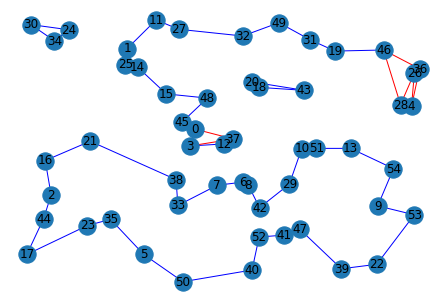

    high degrees
0            4.0
3            4.0
4            4.0
26           4.0
28           4.0
36           4.0
37           4.0
46           4.0


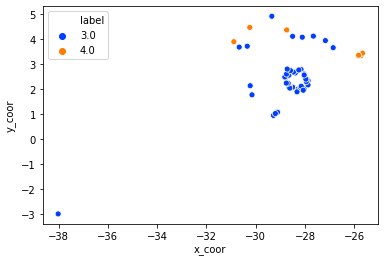

Distribution: normal
Number of nodes: 64
Labels: [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]
Model prediction: [[0.83 0.92 0.04 0.13 0.91 0.   0.51 0.2 ]]
Status: Optimal


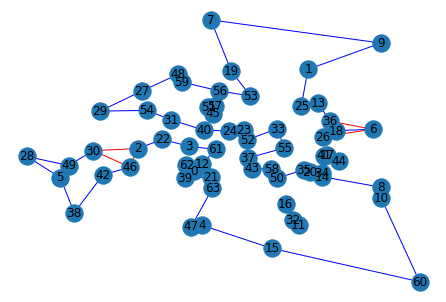

    high degrees
2            4.0
6            4.0
26           4.0
30           4.0
36           4.0
46           4.0


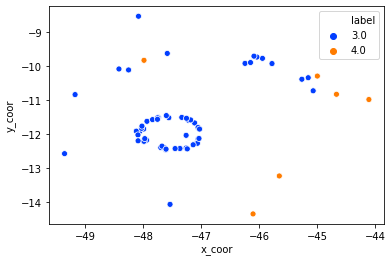

Distribution: exponential
Number of nodes: 55
Labels: [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]
Model prediction: [[0.9  0.55 0.02 0.01 0.61 0.   0.47 0.17]]
Status: Optimal


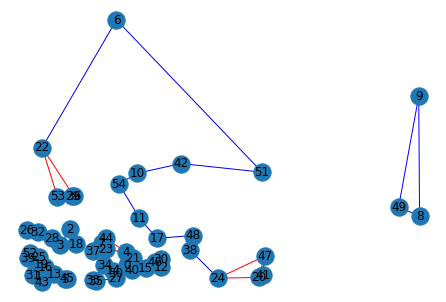

    high degrees
1            4.0
4            4.0
12           4.0
15           4.0
16           4.0
19           4.0
20           4.0
22           4.0
23           4.0
24           4.0
25           4.0
31           4.0
36           4.0
39           4.0
44           4.0
46           4.0
47           4.0
53           4.0


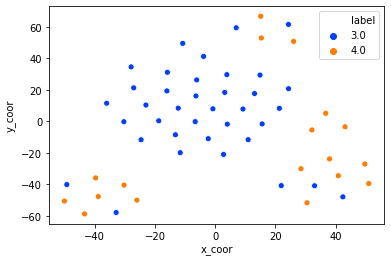

Distribution: balanced_tree
Number of nodes: 73
Labels: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Model prediction: [[0.84 0.   0.   0.   0.   0.   0.23 0.13]]
Status: Optimal


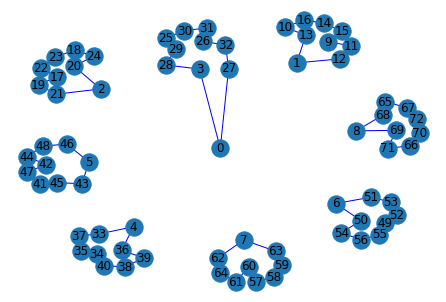

Empty DataFrame
Columns: [high degrees]
Index: []


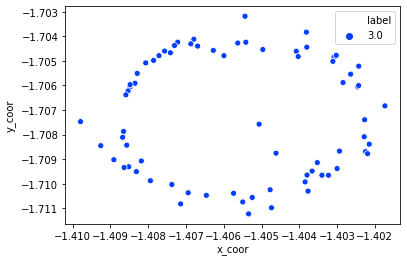

Distribution: barbell
Number of nodes: 59
Labels: [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]
Model prediction: [[0.86 0.7  0.   0.72 0.72 0.   0.38 0.22]]
Status: Optimal


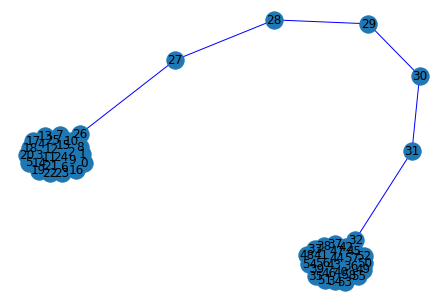

    high degrees
3            4.0
18           4.0
20           4.0
33           4.0
34           4.0
37           4.0
41           4.0
42           4.0
46           4.0
47           4.0
48           4.0
51           4.0


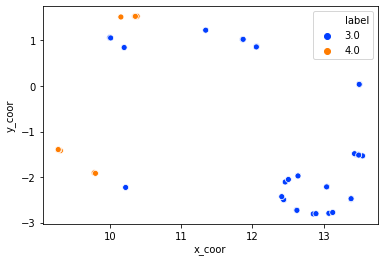

Distribution: complete_multipartite
Number of nodes: 69
Labels: [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
Model prediction: [[0.86 0.87 0.01 0.85 0.88 0.   0.57 0.27]]
Status: Optimal


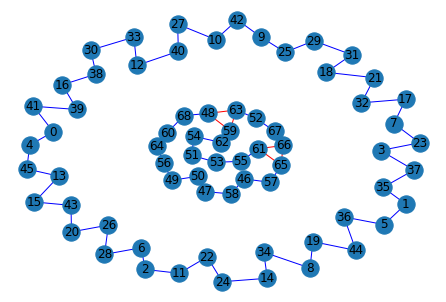

    high degrees
48           4.0
59           4.0
61           4.0
63           4.0
65           4.0
66           4.0


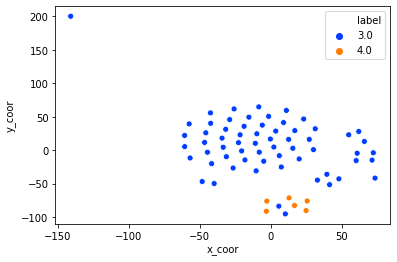

Distribution: circular_ladder
Number of nodes: 46
Labels: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Model prediction: [[0.84 0.   0.   0.   0.   0.   0.23 0.13]]
Status: Optimal


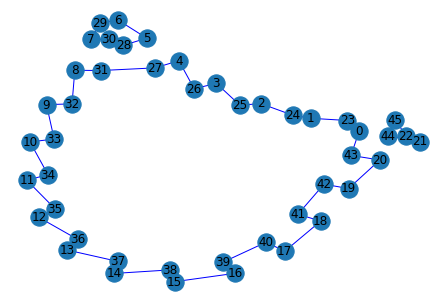

Empty DataFrame
Columns: [high degrees]
Index: []


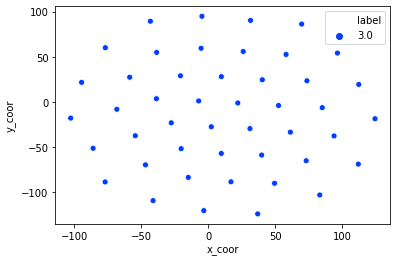

Distribution: ladder
Number of nodes: 42
Labels: [0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
Model prediction: [[0.44 0.97 0.94 0.5  0.96 0.04 0.41 0.33]]
Status: Optimal


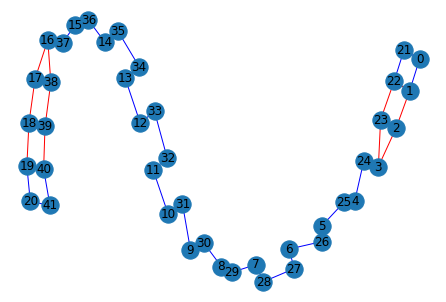

    high degrees
1            4.0
2            4.0
3            4.0
16           4.0
17           4.0
18           4.0
19           4.0
22           4.0
23           4.0
38           4.0
39           4.0
40           4.0


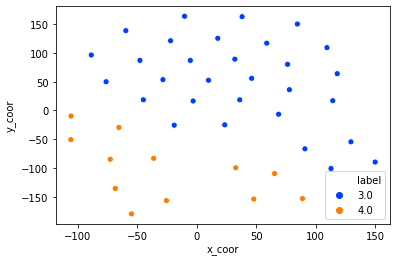

Distribution: star
Number of nodes: 50
Labels: [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
Model prediction: [[0.87 0.85 0.   0.8  0.86 0.   0.49 0.26]]
Status: Optimal


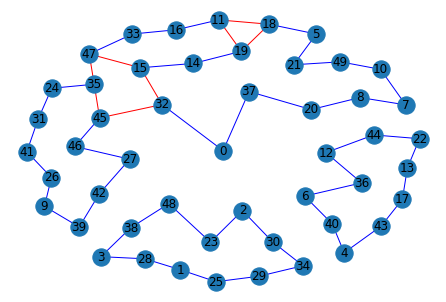

    high degrees
11           4.0
15           4.0
18           4.0
19           4.0
32           4.0
35           4.0
45           4.0
47           4.0


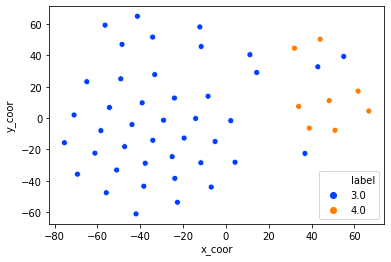

Distribution: cavemen
Number of nodes: 63
Labels: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Model prediction: [[0.84 0.   0.   0.   0.   0.   0.23 0.13]]
Status: Optimal


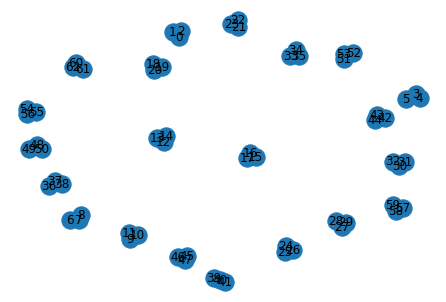

Empty DataFrame
Columns: [high degrees]
Index: []


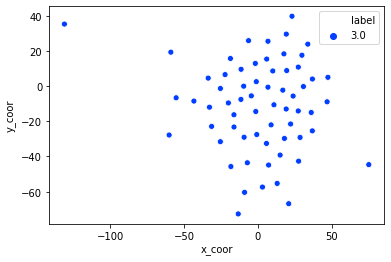

Distribution: lollipop
Number of nodes: 39
Labels: [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
Model prediction: [[0.85 0.93 0.02 0.15 0.93 0.   0.51 0.17]]
Status: Optimal


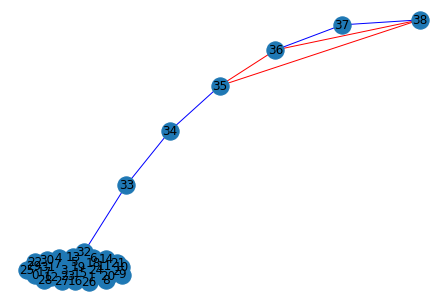

    high degrees
3            4.0
17           4.0
31           4.0
35           4.0
36           4.0
38           4.0


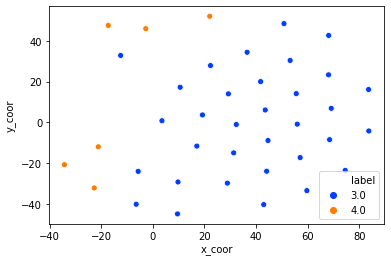

Distribution: grid
Number of nodes: 54
Labels: [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]
Model prediction: [[0.88 0.93 0.01 0.16 0.92 0.   0.53 0.22]]
Status: Optimal


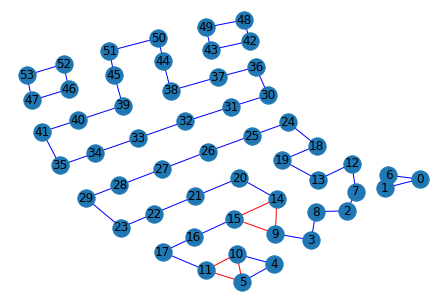

    high degrees
5            4.0
9            4.0
10           4.0
11           4.0
14           4.0
15           4.0


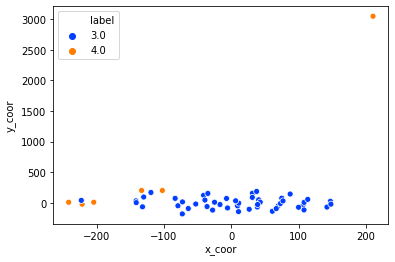

Distribution: ring_of_cliques
Number of nodes: 64
Labels: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Model prediction: [[0.82 0.01 0.01 0.   0.02 0.   0.43 0.08]]
Status: Optimal


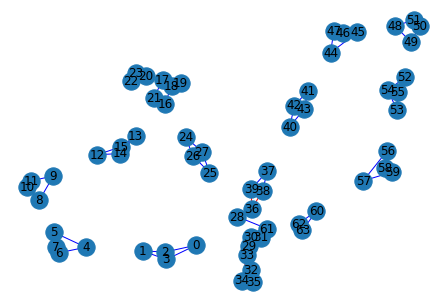

    high degrees
32           4.0
33           4.0
34           4.0
36           4.0
38           4.0
39           4.0


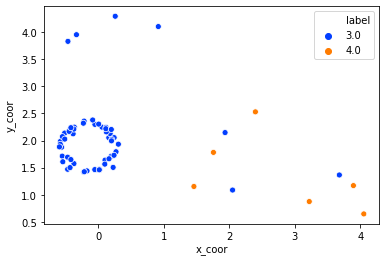

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

for k in range(len(tsp_list)): 
    print('Distribution:', tsp_list[k][1])
    print('Number of nodes:', tsp_list[k][0])
 
    tsp_id = tsp_list[k][2]
    labels1 = labels_keep[labels_keep['tsp_id'] == tsp_id].iloc[0]
    
    print('Labels:', list(labels1[:-2]))
    
    index1 =  labels1.name
    case1 = graphs[index1]

    prediction, g_emb, node_emb = GCN1(case1)
    print("Model prediction:", np.round(prediction.detach().numpy(), 2))

    problem1 = act.init_prob(tsp_id, tsp_list[k][3], 1, 'continuous')

    #node_emb = case1.ndata['h'].detach().numpy()
    degrees = pd.DataFrame(case1.in_degrees().view(-1, 1).float().detach().numpy())
    degrees_ = degrees[degrees[0] > 3]
    print(degrees_.rename(columns={0:'high degrees'}))

    # Node embeddings
    X = pd.DataFrame(node_emb)
    X_embedded = pd.DataFrame(TSNE(n_components=2, n_iter=3000).fit_transform(np.array(X)))
    X_embedded['label'] = list(degrees[0])
    X_embedded = X_embedded.rename(columns={0: 'x_coor', 1:'y_coor'})
    palette = sns.color_palette("bright", len(np.unique(degrees[0])))  #Choosing color
    sns.scatterplot("x_coor",  "y_coor", hue='label', data=X_embedded, legend='full', palette=palette)
    # Put the legend out of the figure
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

**Check performance on training graphs**

In [ ]:
def perfo(pred, k, label, model):
    print("Distribution of target (inequality):", k)
    ax = sns.distplot(pred)
    plt.show()
    best_roc_thold, roc_ = gm.draw_roc_curve(label, pred) # Highest TPR - FPR
    f1_x, best_f1_thold = gm.draw_precision_recall_curve(label, pred) # Highest F1 Score

    pred_1 = [1 if elem >= best_roc_thold else 0 for elem in pred]
    pred_2 = [1 if elem >= best_f1_thold else 0 for elem in pred]

    print("target:", k, "actual target=1 ratio:", round(sum(label)/len(label), 2))
    print("target:", k, "predicted as target=1 ratio wrt best ROC thold:", round(sum(pred_1)/len(pred_1), 2))
    print("target:", k, "predicted as target=1 ratio wrt best F1 thold:", round(sum(pred_2)/len(pred_2), 2))

    recall_roc_thold = round(recall_score(label, pred_1), 3)
    recall_f1_thold = round(recall_score(label, pred_2), 3)
    
    acc_roc_thold = round(accuracy_score(label, pred_1), 3)
    acc_f1_thold = round(accuracy_score(label, pred_2), 3)

    f1_roc_thold = round(f1_score(label, pred_1), 3)
    f1_f1_thold = round(f1_score(label, pred_2), 3)

    print('comparison of F1-scores:', round(f1_x, 3), f1_f1_thold)

    obj1 = {'ineq': k, 
            'model': model, 
            'roc score' : round(roc_, 3), 
            'recall roc thold': recall_roc_thold, 
            'recall f1 thold': recall_f1_thold,
            'accuracy roc thold': acc_roc_thold, 
            'accuracy f1 thold': acc_f1_thold,
            'f1 roc thold': f1_roc_thold, 
            'f1 f1 thold': f1_f1_thold,
            'best roc thold': best_roc_thold,
            'best f1 thold': best_f1_thold
          }

    return obj1

In [ ]:
train_predictions1 = []
train_predictions2 = []
train_predictions3 = []
train_predictions4 = []
train_predictions5 = []
train_predictions6 = []

In [ ]:
train_predictions11 = []
train_predictions22 = []

In [ ]:
for k in range(len(graphs)): 
    #print("predicting (training) graph:", k)
    # predict 
    new_state = graphs[k]
    prediction1, g_emb1, n_emb1 = GCN1(new_state)
    prediction2, g_emb2, n_emb2 = GCN2(new_state)
    prediction3, g_emb3, n_emb3 = GCN3(new_state)
    prediction4, g_emb4, n_emb4 = GAT1(new_state)
    prediction5, g_emb5, n_emb5 = GAT2(new_state)
    prediction6, g_emb6, n_emb6 = GAT3(new_state)

    train_predictions1.append(prediction1.detach().numpy()[0].tolist())
    train_predictions2.append(prediction2.detach().numpy()[0].tolist())
    train_predictions3.append(prediction3.detach().numpy()[0].tolist())
    train_predictions4.append(prediction4.detach().numpy()[0].tolist())
    train_predictions5.append(prediction5.detach().numpy()[0].tolist())
    train_predictions6.append(prediction6.detach().numpy()[0].tolist())

In [ ]:
for k in range(len(graphs)): 
    #print("predicting (training) graph:", k)
    # predict 
    new_state = graphs[k]
    prediction1, g_emb1, n_emb1 = GCN11(new_state)
    #prediction2, g_emb2, n_emb2 = GCN22(new_state)
    prediction2, g_emb2, n_emb2 = GAT11(new_state)

    train_predictions11.append(prediction1.detach().numpy()[0].tolist())
    train_predictions22.append(prediction2.detach().numpy()[0].tolist())

In [ ]:
PRED1 = pd.DataFrame(train_predictions1)
PRED2 = pd.DataFrame(train_predictions2)
PRED3 = pd.DataFrame(train_predictions3)
PRED4 = pd.DataFrame(train_predictions4)
PRED5 = pd.DataFrame(train_predictions5)
PRED6 = pd.DataFrame(train_predictions6)

In [ ]:
PRED11 = pd.DataFrame(train_predictions11)
PRED22 = pd.DataFrame(train_predictions22)
picked_tholds = pd.DataFrame()

In [ ]:
print("Performance on training graphs")
for k in range(len(weights)):
    pred1 = PRED1[k] # GCN mean
    pred2 = PRED2[k] # GCN max
    pred3 = PRED3[k] # GCN sum
    pred4 = PRED4[k] # GAT mean
    pred5 = PRED5[k] # GAT max
    pred6 = PRED6[k] # GAT sum

    pred12 = (PRED1[k] + PRED2[k])/2 # Ensemble GCN 1-2
    pred13 = (PRED1[k] + PRED3[k])/2 # Ensemble GCN 1-3
    pred23 = (PRED2[k] + PRED3[k])/2 # Ensemble GCN 2-3
    pred123 = (PRED1[k] + PRED2[k] + PRED3[k])/3 # Ensemble GCNs


    pred45 = (PRED4[k] + PRED5[k])/2 # Ensemble GAT 4-5
    pred46 = (PRED4[k] + PRED6[k])/2 # Ensemble GAT 4-6
    pred56 = (PRED5[k] + PRED6[k])/2 # Ensemble GAT 5-6
    pred456 = (PRED4[k] + PRED5[k] + PRED6[k])/3 # Ensemble GATs

    pred14 = (PRED1[k] + PRED4[k])/2 # Ensemble GCN - GAT MEAN
    pred25 = (PRED2[k] + PRED5[k])/2 # Ensemble GCN - GAT MAX
    pred36 = (PRED3[k] + PRED6[k])/2 # Ensemble GCN - GAT SUM

    label = labels[str(k)] # TRUE LABEL

    print("Results of GCN1")
    obj1 = perfo(pred1, k, label, 'GCN1')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj1, index=[0]))
    print("Results of GCN2")
    obj2 = perfo(pred2, k, label, 'GCN2')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj2, index=[0]))
    print("Results of GCN3")
    obj3 = perfo(pred3, k, label, 'GCN3')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj3, index=[0]))
    print("Results of GCN1-2")
    obj12 = perfo(pred12, k, label, 'GCN12')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj12, index=[0]))
    print("Results of GCN1-3")
    obj13 = perfo(pred13, k, label, 'GCN13')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj13, index=[0]))
    print("Results of GCN2-3")
    obj23 = perfo(pred23, k, label, 'GCN23')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj23, index=[0]))
    print("Results of GCN1-2-3")
    obj123 = perfo(pred123, k, label, 'GCN123')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj123, index=[0]))

    print("Results of GAT4")
    obj4 = perfo(pred4, k, label, 'GAT4')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj4, index=[0]))
    print("Results of GAT5")
    obj5 = perfo(pred5, k, label, 'GAT5')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj5, index=[0]))
    print("Results of GAT6")
    obj6 = perfo(pred6, k, label, 'GAT6')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj6, index=[0]))
    print("Results of GAT4-5")
    obj45 = perfo(pred45, k, label, 'GAT45')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj45, index=[0]))
    print("Results of GAT4-6")
    obj46 = perfo(pred46, k, label, 'GAT46')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj46, index=[0]))
    print("Results of GAT5-6")
    obj56 = perfo(pred56, k, label, 'GAT56')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj56, index=[0]))
    print("Results of GAT4-5-6")
    obj456 = perfo(pred456, k, label, 'GAT456')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj456, index=[0]))

    print("GCN1 - GAT1")
    obj14 =  perfo(pred14, k, label, 'GCN-GAT MN')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj14, index=[0]))
    print("GCN2 - GAT2")
    obj25 =  perfo(pred25, k, label, 'GCN-GAT MX')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj25, index=[0]))
    print("GCN3 - GAT3")
    obj36 =  perfo(pred36, k, label, 'GCN-GAT SU')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj36, index=[0]))

Performance on training graphs 2
Results of GCN11
Distribution of target (inequality): 0


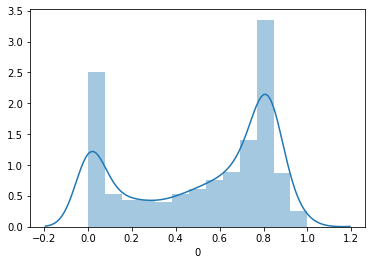

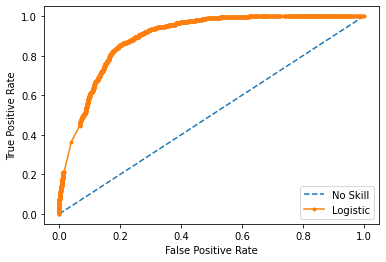

According to ROC Curve - Best Threshold=0.568465
According to precision recall curve: Best Threshold=0.448429, F-Score=0.851


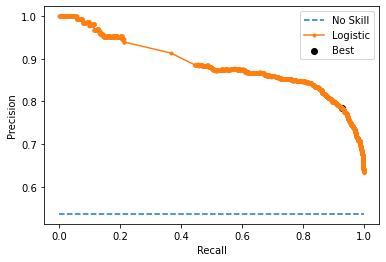

target: 0 actual target=1 ratio: 0.54
target: 0 predicted as target=1 ratio wrt best ROC thold: 0.55
target: 0 predicted as target=1 ratio wrt best F1 thold: 0.63
comparison of F1-scores: 0.851 0.851
Distribution of target (inequality): 0


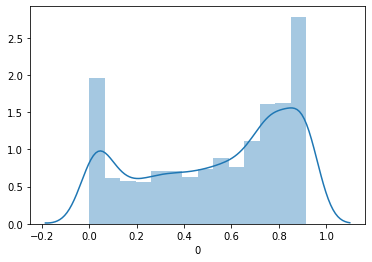

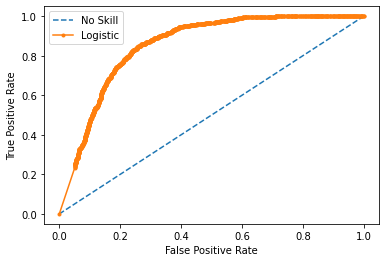

According to ROC Curve - Best Threshold=0.506885
According to precision recall curve: Best Threshold=0.359976, F-Score=0.828


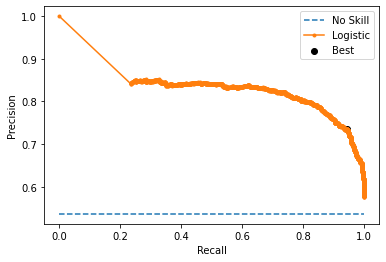

target: 0 actual target=1 ratio: 0.54
target: 0 predicted as target=1 ratio wrt best ROC thold: 0.58
target: 0 predicted as target=1 ratio wrt best F1 thold: 0.69
comparison of F1-scores: 0.828 0.828
Results of GCN11
Distribution of target (inequality): 1


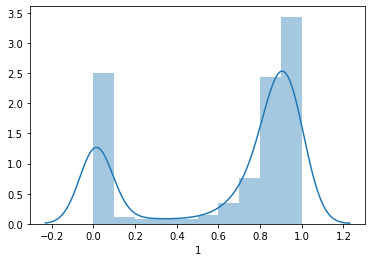

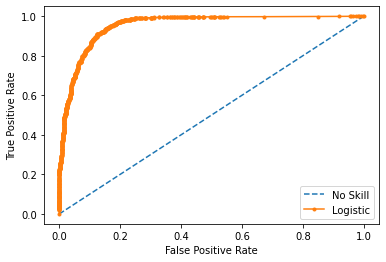

According to ROC Curve - Best Threshold=0.757113
According to precision recall curve: Best Threshold=0.647223, F-Score=0.933


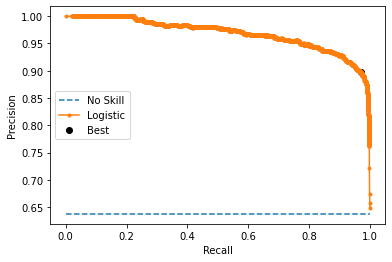

target: 1 actual target=1 ratio: 0.64
target: 1 predicted as target=1 ratio wrt best ROC thold: 0.63
target: 1 predicted as target=1 ratio wrt best F1 thold: 0.69
comparison of F1-scores: 0.933 0.933
Distribution of target (inequality): 1


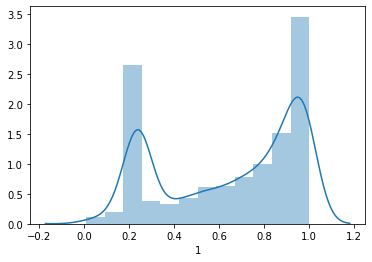

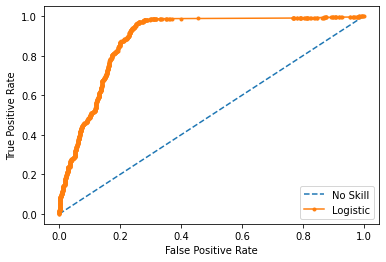

According to ROC Curve - Best Threshold=0.403995
According to precision recall curve: Best Threshold=0.328653, F-Score=0.916


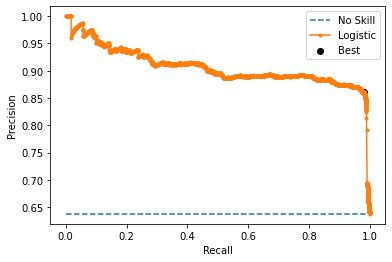

target: 1 actual target=1 ratio: 0.64
target: 1 predicted as target=1 ratio wrt best ROC thold: 0.7
target: 1 predicted as target=1 ratio wrt best F1 thold: 0.73
comparison of F1-scores: 0.916 0.916
Results of GCN11
Distribution of target (inequality): 2


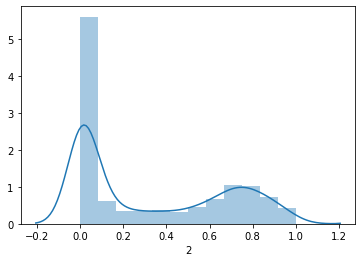

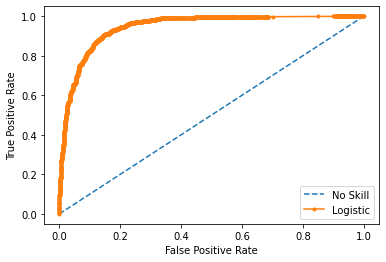

According to ROC Curve - Best Threshold=0.438794
According to precision recall curve: Best Threshold=0.540987, F-Score=0.819


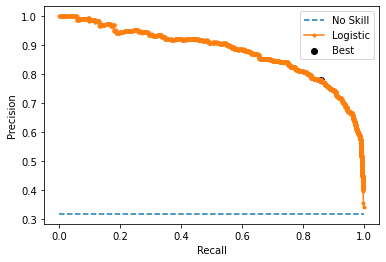

target: 2 actual target=1 ratio: 0.32
target: 2 predicted as target=1 ratio wrt best ROC thold: 0.39
target: 2 predicted as target=1 ratio wrt best F1 thold: 0.35
comparison of F1-scores: 0.819 0.819
Distribution of target (inequality): 2


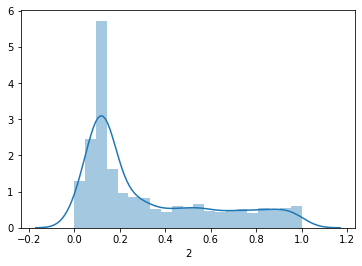

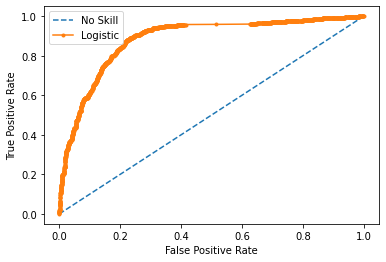

According to ROC Curve - Best Threshold=0.226104
According to precision recall curve: Best Threshold=0.226104, F-Score=0.746


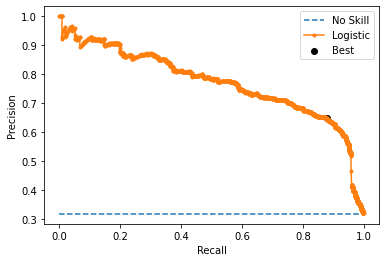

target: 2 actual target=1 ratio: 0.32
target: 2 predicted as target=1 ratio wrt best ROC thold: 0.43
target: 2 predicted as target=1 ratio wrt best F1 thold: 0.43
comparison of F1-scores: 0.746 0.746
Results of GCN11
Distribution of target (inequality): 3


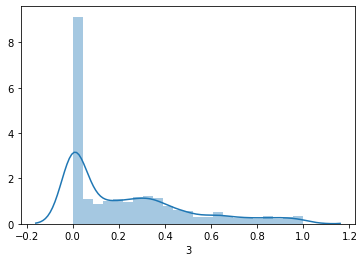

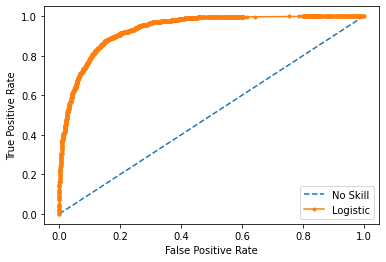

According to ROC Curve - Best Threshold=0.309448
According to precision recall curve: Best Threshold=0.354564, F-Score=0.750


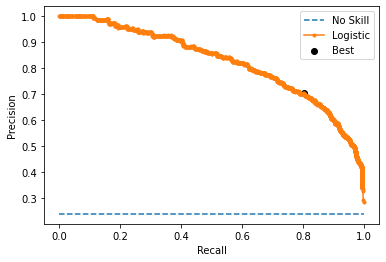

target: 3 actual target=1 ratio: 0.24
target: 3 predicted as target=1 ratio wrt best ROC thold: 0.33
target: 3 predicted as target=1 ratio wrt best F1 thold: 0.27
comparison of F1-scores: 0.75 0.75
Distribution of target (inequality): 3


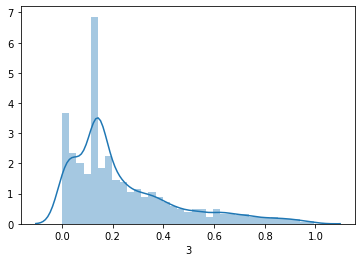

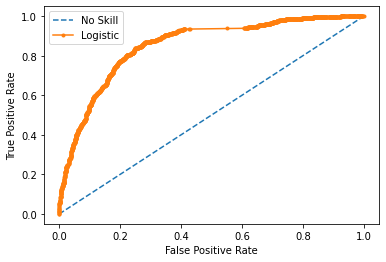

According to ROC Curve - Best Threshold=0.217048
According to precision recall curve: Best Threshold=0.254756, F-Score=0.641


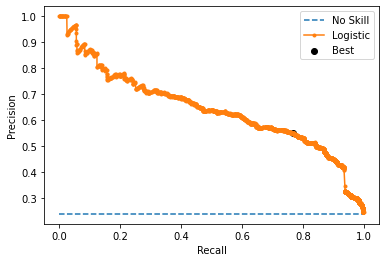

target: 3 actual target=1 ratio: 0.24
target: 3 predicted as target=1 ratio wrt best ROC thold: 0.39
target: 3 predicted as target=1 ratio wrt best F1 thold: 0.33
comparison of F1-scores: 0.641 0.641
Results of GCN11
Distribution of target (inequality): 4


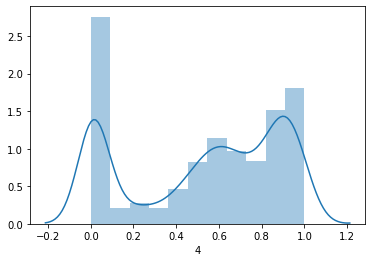

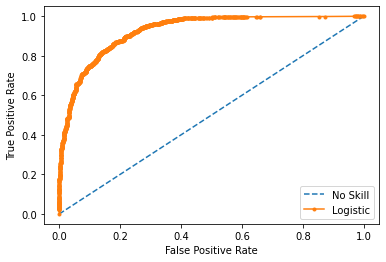

According to ROC Curve - Best Threshold=0.569288
According to precision recall curve: Best Threshold=0.484434, F-Score=0.863


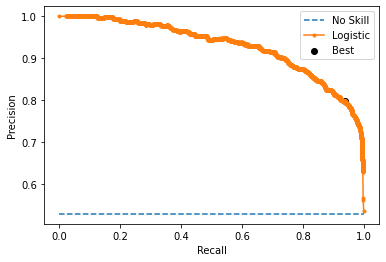

target: 4 actual target=1 ratio: 0.53
target: 4 predicted as target=1 ratio wrt best ROC thold: 0.54
target: 4 predicted as target=1 ratio wrt best F1 thold: 0.62
comparison of F1-scores: 0.863 0.863
Distribution of target (inequality): 4


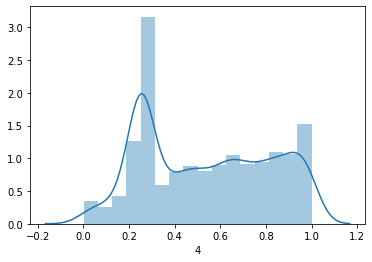

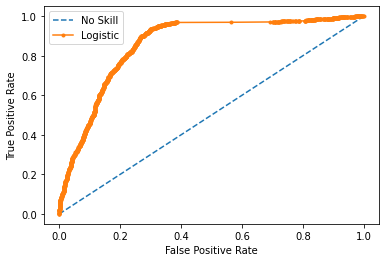

According to ROC Curve - Best Threshold=0.354064
According to precision recall curve: Best Threshold=0.320259, F-Score=0.849


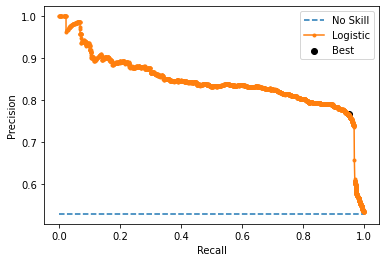

target: 4 actual target=1 ratio: 0.53
target: 4 predicted as target=1 ratio wrt best ROC thold: 0.63
target: 4 predicted as target=1 ratio wrt best F1 thold: 0.66
comparison of F1-scores: 0.849 0.849
Results of GCN11
Distribution of target (inequality): 5


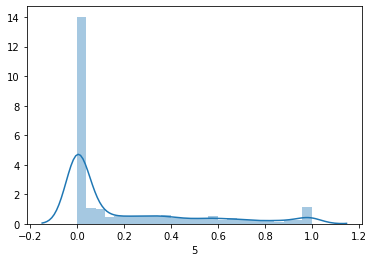

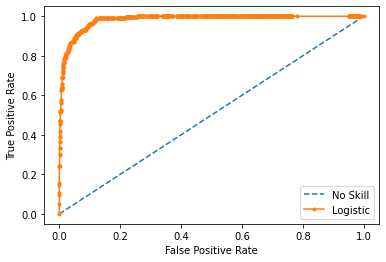

According to ROC Curve - Best Threshold=0.252194
According to precision recall curve: Best Threshold=0.432499, F-Score=0.864


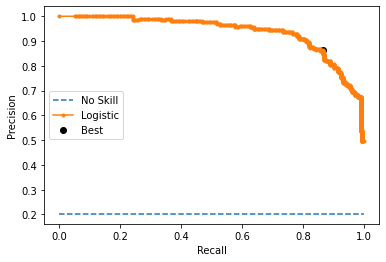

target: 5 actual target=1 ratio: 0.2
target: 5 predicted as target=1 ratio wrt best ROC thold: 0.3
target: 5 predicted as target=1 ratio wrt best F1 thold: 0.2
comparison of F1-scores: 0.864 0.864
Distribution of target (inequality): 5


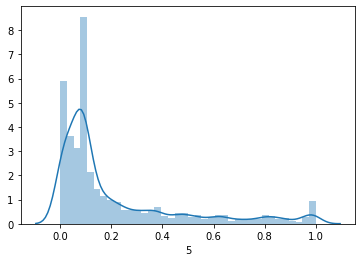

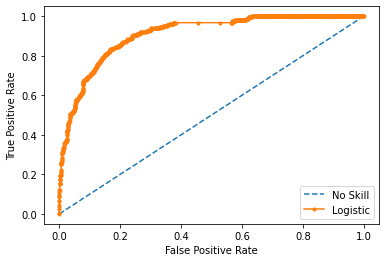

According to ROC Curve - Best Threshold=0.201551
According to precision recall curve: Best Threshold=0.362273, F-Score=0.679


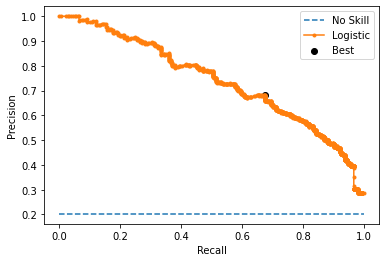

target: 5 actual target=1 ratio: 0.2
target: 5 predicted as target=1 ratio wrt best ROC thold: 0.3
target: 5 predicted as target=1 ratio wrt best F1 thold: 0.2
comparison of F1-scores: 0.679 0.679
Results of GCN11
Distribution of target (inequality): 6


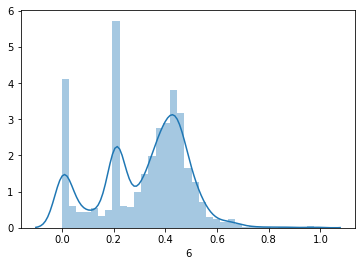

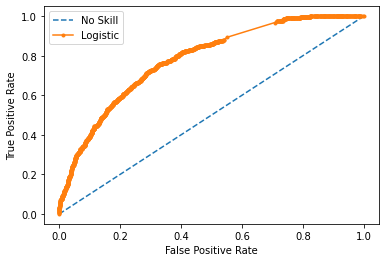

According to ROC Curve - Best Threshold=0.374608
According to precision recall curve: Best Threshold=0.374608, F-Score=0.618


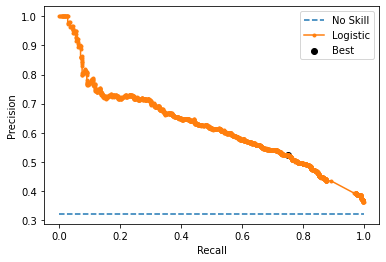

target: 6 actual target=1 ratio: 0.32
target: 6 predicted as target=1 ratio wrt best ROC thold: 0.46
target: 6 predicted as target=1 ratio wrt best F1 thold: 0.46
comparison of F1-scores: 0.618 0.618
Distribution of target (inequality): 6


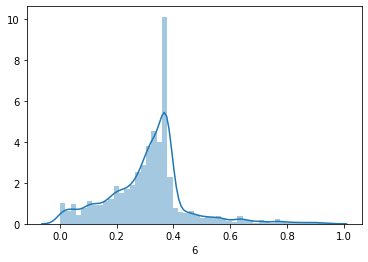

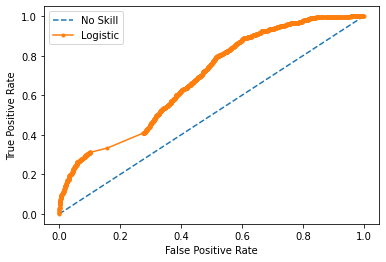

According to ROC Curve - Best Threshold=0.263336
According to precision recall curve: Best Threshold=0.263336, F-Score=0.561


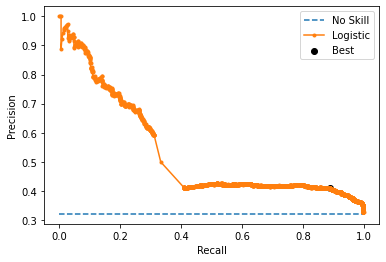

target: 6 actual target=1 ratio: 0.32
target: 6 predicted as target=1 ratio wrt best ROC thold: 0.7
target: 6 predicted as target=1 ratio wrt best F1 thold: 0.7
comparison of F1-scores: 0.561 0.561
Results of GCN11
Distribution of target (inequality): 7


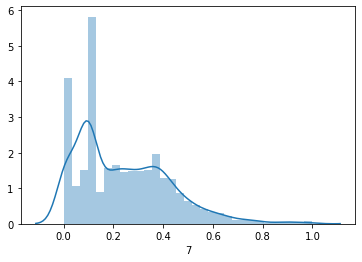

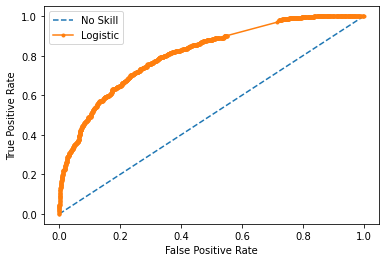

According to ROC Curve - Best Threshold=0.299560
According to precision recall curve: Best Threshold=0.347269, F-Score=0.574


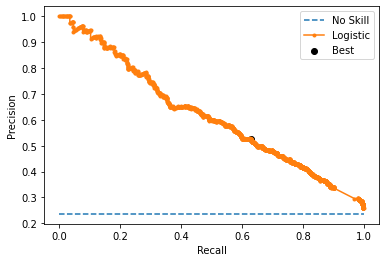

target: 7 actual target=1 ratio: 0.24
target: 7 predicted as target=1 ratio wrt best ROC thold: 0.36
target: 7 predicted as target=1 ratio wrt best F1 thold: 0.28
comparison of F1-scores: 0.574 0.574
Distribution of target (inequality): 7


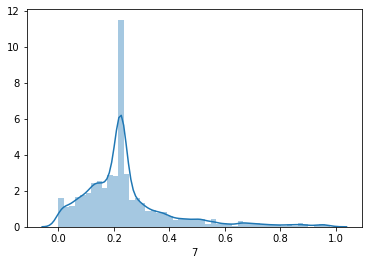

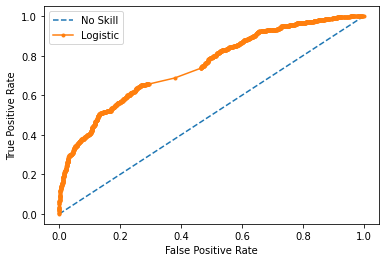

According to ROC Curve - Best Threshold=0.230698
According to precision recall curve: Best Threshold=0.297613, F-Score=0.524


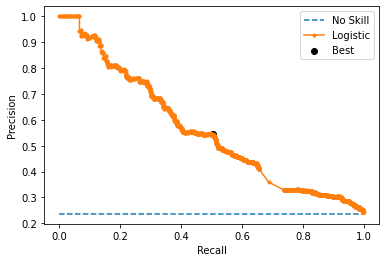

target: 7 actual target=1 ratio: 0.24
target: 7 predicted as target=1 ratio wrt best ROC thold: 0.36
target: 7 predicted as target=1 ratio wrt best F1 thold: 0.22
comparison of F1-scores: 0.524 0.524


In [ ]:
print("Performance on training graphs 2")
for k in range(len(weights)):
    pred1 = PRED11[k] # GCN mean
    pred2 = PRED22[k] # GCN max
 
    label = labels[str(k)] # TRUE LABEL

    print("Results of GCN11")
    obj1 = perfo(pred1, k, label, 'GCN11_NEG')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj1, index=[0]))
    #print("Results of GCN22")
    #obj2 = perfo(pred2, k, label, 'GCN22')
    #picked_tholds = picked_tholds.append(pd.DataFrame(obj2, index=[0]))
    obj2 = perfo(pred2, k, label, 'GAT11_NEG')
    picked_tholds = picked_tholds.append(pd.DataFrame(obj2, index=[0]))


In [ ]:
# download performance metrics
picked_tholds.to_csv('picked_thold_train_NEG.csv')
files.download('picked_thold_train_NEG.csv') 

**Collect embeddings and predict**

In [ ]:
l11 = pd.read_csv("TEST_LABELS1.csv")
test_labels = l11.reset_index(drop=True)
test_labels = test_labels.iloc[:,1:10]
len(test_labels)
test_labels.head()

,0,1,2,3,4,5,6,7,8
0,15.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0
3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0


In [ ]:
g11 = load_graphs("test_graphs1.bin")
test_graphs = g11[0] 

len(test_graphs)

1068

**Make targets binary**

In [ ]:
test_labels['0'] = np.where(test_labels['0']>0, 1.0, 0.0)
test_labels['1'] = np.where(test_labels['1']>0, 1.0, 0.0)
test_labels['2'] = np.where(test_labels['2']>0, 1.0, 0.0)
test_labels['3'] = np.where(test_labels['3']>0, 1.0, 0.0)
test_labels['4'] = np.where(test_labels['4']>0, 1.0, 0.0)
test_labels['5'] = np.where(test_labels['5']>0, 1.0, 0.0)
test_labels['6'] = np.where(test_labels['6']>0, 1.0, 0.0)
test_labels['7'] = np.where(test_labels['7']>0, 1.0, 0.0)
test_labels['8'] = np.where(test_labels['8']>0, 1.0, 0.0)
test_labels.head()

,0,1,2,3,4,5,6,7,8
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Ignored envelopes due to lack of target=1 
test_labels = test_labels.drop(['6'], axis=1)

# change column names for convenience 
test_labels = test_labels.rename(columns={'7':'6', '8':'7'})
test_labels.head()

,0,1,2,3,4,5,6,7
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# target distributions
class1 = round(test_labels.sum()/len(test_labels)*100, 1)
class1

0    47.0
1    76.6
2    36.8
3    27.4
4    58.5
5     6.6
6    28.2
7    21.9
dtype: float64

In [ ]:
test_predictions1 = []
test_predictions2 = []
test_predictions3 = []
test_predictions4 = []
test_predictions5 = []
test_predictions6 = []

In [ ]:
for k in range(len(test_graphs)): 
    #print("predicting (test) graph:", k)
    # predict 
    new_state = test_graphs[k]
    prediction1, g_emb1, n_emb1 = GCN1(new_state)
    prediction2, g_emb2, n_emb2 = GCN2(new_state)
    prediction3, g_emb3, n_emb3 = GCN3(new_state)
    prediction4, g_emb4, n_emb4 = GAT1(new_state)
    prediction5, g_emb5, n_emb5 = GAT2(new_state)
    prediction6, g_emb6, n_emb6 = GAT3(new_state)

    test_predictions1.append(prediction1.detach().numpy()[0].tolist())
    test_predictions2.append(prediction2.detach().numpy()[0].tolist())
    test_predictions3.append(prediction3.detach().numpy()[0].tolist())
    test_predictions4.append(prediction4.detach().numpy()[0].tolist())
    test_predictions5.append(prediction5.detach().numpy()[0].tolist())
    test_predictions6.append(prediction6.detach().numpy()[0].tolist())

In [ ]:
for k in range(len(test_graphs)): 
    #print("predicting (test) graph:", k)
    # predict 
    new_state = test_graphs[k]
    prediction1, g_emb1, n_emb1 = GCN11(new_state)
    #prediction2, g_emb2, n_emb2 = GCN22(new_state)
    prediction2, g_emb2, n_emb2 = GAT11(new_state)

    test_predictions1.append(prediction1.detach().numpy()[0].tolist())
    test_predictions2.append(prediction2.detach().numpy()[0].tolist())

In [ ]:
PRED1 = pd.DataFrame(test_predictions1)
PRED2 = pd.DataFrame(test_predictions2)
PRED3 = pd.DataFrame(test_predictions3)
PRED4 = pd.DataFrame(test_predictions4)
PRED5 = pd.DataFrame(test_predictions5)
PRED6 = pd.DataFrame(test_predictions6)

In [ ]:
PRED11 = pd.DataFrame(test_predictions1)
PRED22 = pd.DataFrame(test_predictions2)
picked_tholds_test = pd.DataFrame()

In [ ]:
print("Performance on test graphs")
for k in range(len(weights)):
    pred1 = PRED1[k] # GCN mean
    pred2 = PRED2[k] # GCN max
    pred3 = PRED3[k] # GCN sum
    pred4 = PRED4[k] # GAT mean
    pred5 = PRED5[k] # GAT max
    pred6 = PRED6[k] # GAT sum

    pred12 = (PRED1[k] + PRED2[k])/2 # Ensemble GCN 1-2
    pred13 = (PRED1[k] + PRED3[k])/2 # Ensemble GCN 1-3
    pred23 = (PRED2[k] + PRED3[k])/2 # Ensemble GCN 2-3
    pred123 = (PRED1[k] + PRED2[k] + PRED3[k])/3 # Ensemble GCNs

    pred45 = (PRED4[k] + PRED5[k])/2 # Ensemble GAT 4-5
    pred46 = (PRED4[k] + PRED6[k])/2 # Ensemble GAT 4-6
    pred56 = (PRED5[k] + PRED6[k])/2 # Ensemble GAT 5-6
    pred456 = (PRED4[k] + PRED5[k] + PRED6[k])/3 # Ensemble GATs

    pred14 = (PRED1[k] + PRED4[k])/2 # Ensemble GCN - GAT MEAN
    pred25 = (PRED2[k] + PRED5[k])/2 # Ensemble GCN - GAT MAX
    pred36 = (PRED3[k] + PRED6[k])/2 # Ensemble GCN - GAT SUM

    label = test_labels[str(k)] # TRUE LABEL

    print("Results of GCN1")
    obj1 = perfo(pred1, k, label, 'GCN1')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj1, index=[0]))
    print("Results of GCN2")
    obj2 = perfo(pred2, k, label, 'GCN2')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj2, index=[0]))
    print("Results of GCN3")
    obj3 = perfo(pred3, k, label, 'GCN3')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj3, index=[0]))
    print("Results of GCN1-2")
    obj12 = perfo(pred12, k, label, 'GCN12')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj12, index=[0]))
    print("Results of GCN1-3")
    obj13 = perfo(pred13, k, label, 'GCN13')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj13, index=[0]))
    print("Results of GCN2-3")
    obj23 = perfo(pred23, k, label, 'GCN23')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj23, index=[0]))
    print("Results of GCN1-2-3")
    obj123 = perfo(pred123, k, label, 'GCN123')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj123, index=[0]))

    print("Results of GAT4")
    obj4 = perfo(pred4, k, label, 'GAT4')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj4, index=[0]))
    print("Results of GAT5")
    obj5 = perfo(pred5, k, label, 'GAT5')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj5, index=[0]))
    print("Results of GAT6")
    obj6 = perfo(pred6, k, label, 'GAT6')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj6, index=[0]))
    print("Results of GAT4-5")
    obj45 = perfo(pred45, k, label, 'GAT45')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj45, index=[0]))
    print("Results of GAT4-6")
    obj46 = perfo(pred46, k, label, 'GAT46')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj46, index=[0]))
    print("Results of GAT5-6")
    obj56 = perfo(pred56, k, label, 'GAT56')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj56, index=[0]))
    print("Results of GAT4-5-6")
    obj456 = perfo(pred456, k, label, 'GAT456')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj456, index=[0]))

    print("GCN1 - GAT1")
    obj14 =  perfo(pred14, k, label, 'GCN-GAT MN')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj14, index=[0]))
    print("GCN2 - GAT2")
    obj25 =  perfo(pred25, k, label, 'GCN-GAT MX')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj25, index=[0]))
    print("GCN3 - GAT3")
    obj36 =  perfo(pred36, k, label, 'GCN-GAT SU')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj36, index=[0]))


Performance on test graphs 2
Results of GCN11
Distribution of target (inequality): 0


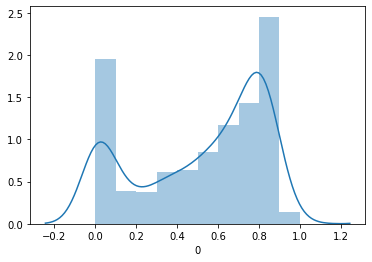

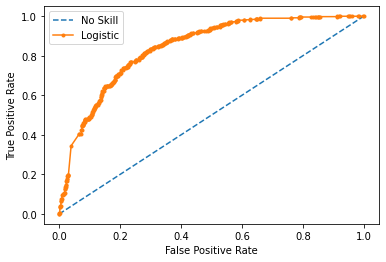

According to ROC Curve - Best Threshold=0.626656
According to precision recall curve: Best Threshold=0.550895, F-Score=0.770


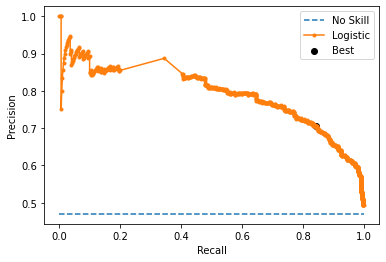

target: 0 actual target=1 ratio: 0.47
target: 0 predicted as target=1 ratio wrt best ROC thold: 0.49
target: 0 predicted as target=1 ratio wrt best F1 thold: 0.56
comparison of F1-scores: 0.77 0.77
Results of GAT11
Distribution of target (inequality): 0


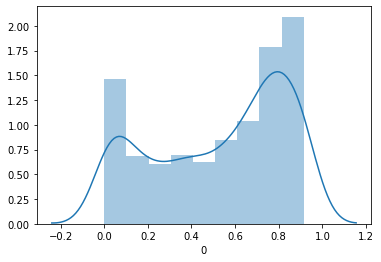

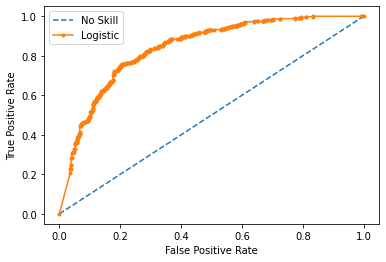

According to ROC Curve - Best Threshold=0.647015
According to precision recall curve: Best Threshold=0.468580, F-Score=0.770


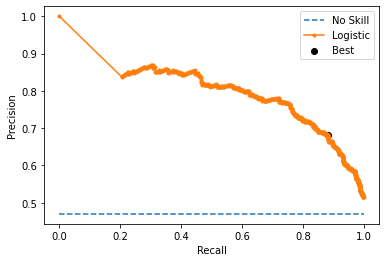

target: 0 actual target=1 ratio: 0.47
target: 0 predicted as target=1 ratio wrt best ROC thold: 0.47
target: 0 predicted as target=1 ratio wrt best F1 thold: 0.61
comparison of F1-scores: 0.77 0.77
Results of GCN11
Distribution of target (inequality): 1


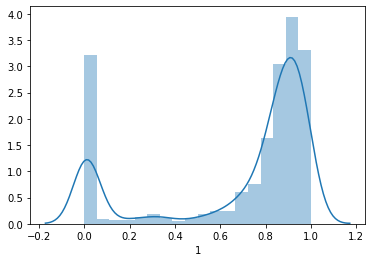

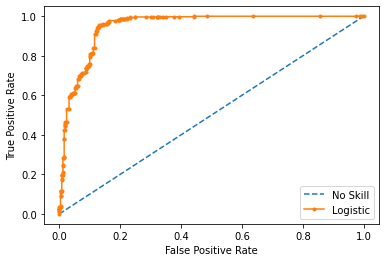

According to ROC Curve - Best Threshold=0.593557
According to precision recall curve: Best Threshold=0.374425, F-Score=0.964


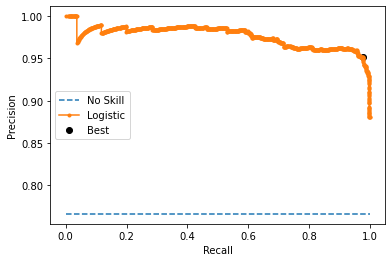

target: 1 actual target=1 ratio: 0.77
target: 1 predicted as target=1 ratio wrt best ROC thold: 0.76
target: 1 predicted as target=1 ratio wrt best F1 thold: 0.79
comparison of F1-scores: 0.964 0.964
Results of GAT11
Distribution of target (inequality): 1


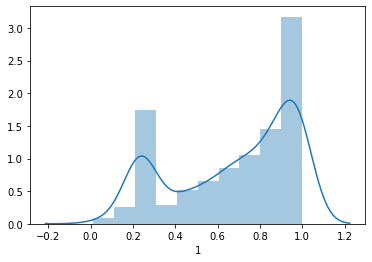

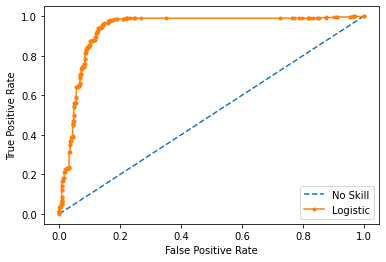

According to ROC Curve - Best Threshold=0.380619
According to precision recall curve: Best Threshold=0.285412, F-Score=0.965


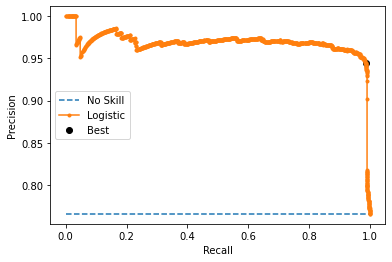

target: 1 actual target=1 ratio: 0.77
target: 1 predicted as target=1 ratio wrt best ROC thold: 0.78
target: 1 predicted as target=1 ratio wrt best F1 thold: 0.8
comparison of F1-scores: 0.965 0.965
Results of GCN11
Distribution of target (inequality): 2


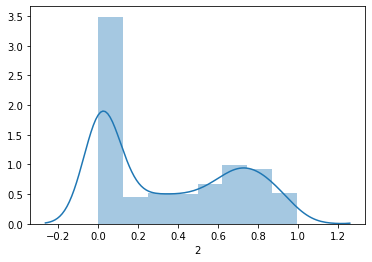

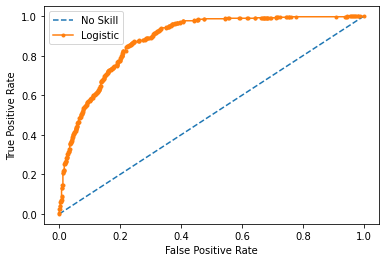

According to ROC Curve - Best Threshold=0.366706
According to precision recall curve: Best Threshold=0.366706, F-Score=0.761


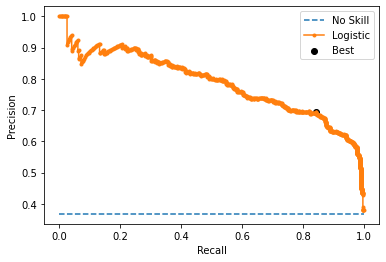

target: 2 actual target=1 ratio: 0.37
target: 2 predicted as target=1 ratio wrt best ROC thold: 0.45
target: 2 predicted as target=1 ratio wrt best F1 thold: 0.45
comparison of F1-scores: 0.761 0.761
Results of GAT11
Distribution of target (inequality): 2


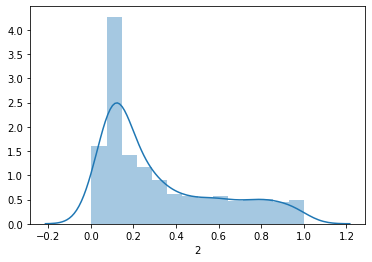

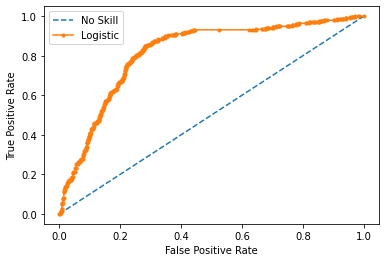

According to ROC Curve - Best Threshold=0.212559
According to precision recall curve: Best Threshold=0.999873, F-Score=nan


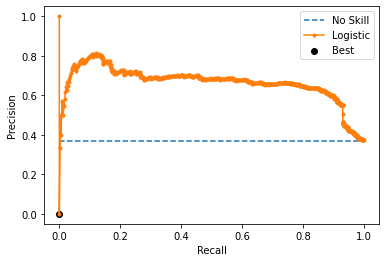

target: 2 actual target=1 ratio: 0.37
target: 2 predicted as target=1 ratio wrt best ROC thold: 0.49
target: 2 predicted as target=1 ratio wrt best F1 thold: 0.0
comparison of F1-scores: nan 0.0
Results of GCN11
Distribution of target (inequality): 3


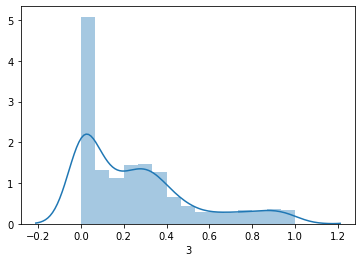

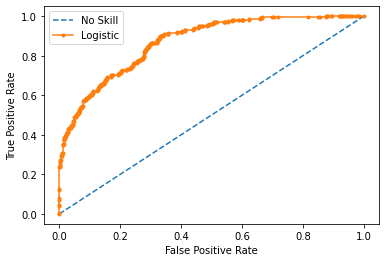

According to ROC Curve - Best Threshold=0.208555
According to precision recall curve: Best Threshold=0.333397, F-Score=0.657


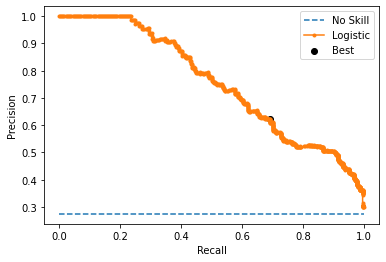

target: 3 actual target=1 ratio: 0.27
target: 3 predicted as target=1 ratio wrt best ROC thold: 0.49
target: 3 predicted as target=1 ratio wrt best F1 thold: 0.3
comparison of F1-scores: 0.657 0.657
Results of GAT11
Distribution of target (inequality): 3


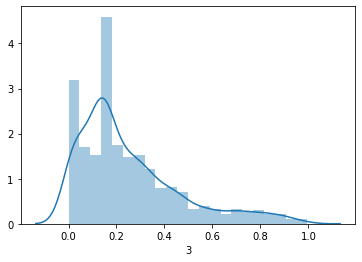

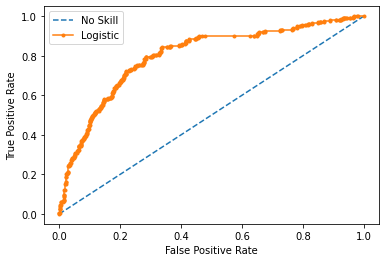

According to ROC Curve - Best Threshold=0.225272
According to precision recall curve: Best Threshold=0.267897, F-Score=0.627


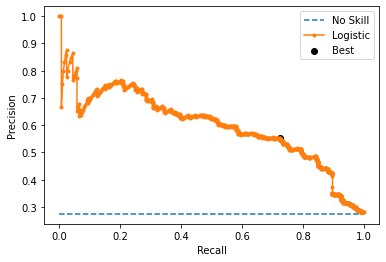

target: 3 actual target=1 ratio: 0.27
target: 3 predicted as target=1 ratio wrt best ROC thold: 0.43
target: 3 predicted as target=1 ratio wrt best F1 thold: 0.36
comparison of F1-scores: 0.627 0.627
Results of GCN11
Distribution of target (inequality): 4


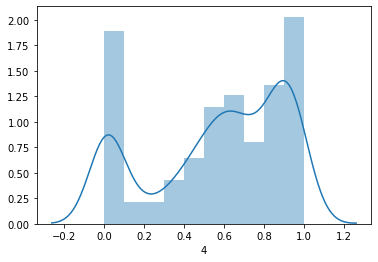

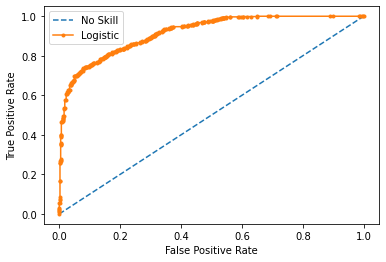

According to ROC Curve - Best Threshold=0.665873
According to precision recall curve: Best Threshold=0.451757, F-Score=0.858


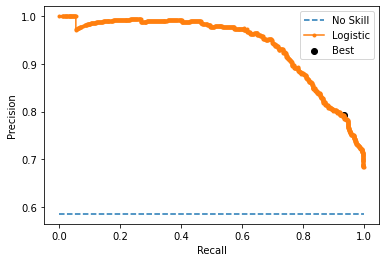

target: 4 actual target=1 ratio: 0.59
target: 4 predicted as target=1 ratio wrt best ROC thold: 0.46
target: 4 predicted as target=1 ratio wrt best F1 thold: 0.69
comparison of F1-scores: 0.858 0.858
Results of GAT11
Distribution of target (inequality): 4


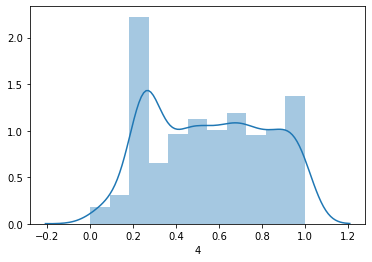

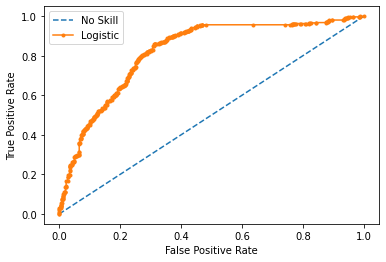

According to ROC Curve - Best Threshold=0.429662
According to precision recall curve: Best Threshold=0.309849, F-Score=0.838


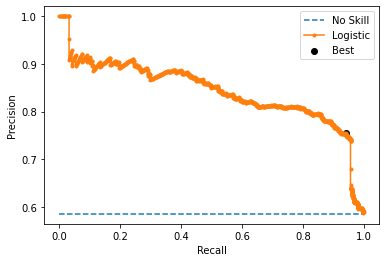

target: 4 actual target=1 ratio: 0.59
target: 4 predicted as target=1 ratio wrt best ROC thold: 0.63
target: 4 predicted as target=1 ratio wrt best F1 thold: 0.73
comparison of F1-scores: 0.838 0.838
Results of GCN11
Distribution of target (inequality): 5


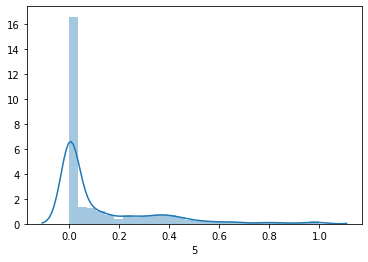

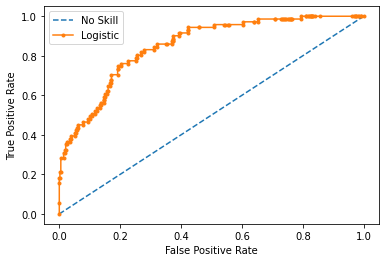

According to ROC Curve - Best Threshold=0.213500
According to precision recall curve: Best Threshold=0.605322, F-Score=0.427


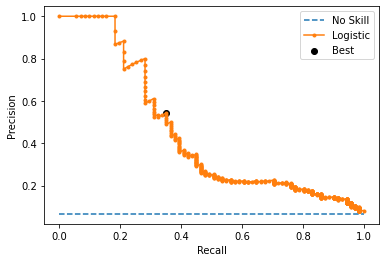

target: 5 actual target=1 ratio: 0.07
target: 5 predicted as target=1 ratio wrt best ROC thold: 0.24
target: 5 predicted as target=1 ratio wrt best F1 thold: 0.04
comparison of F1-scores: 0.427 0.427
Results of GAT11
Distribution of target (inequality): 5


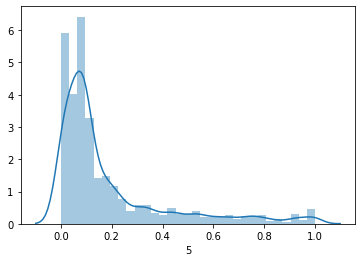

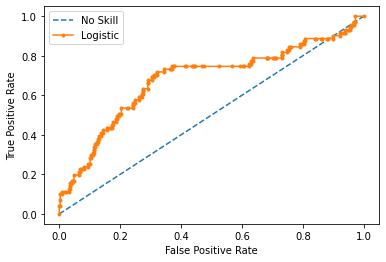

According to ROC Curve - Best Threshold=0.145186
According to precision recall curve: Best Threshold=0.348700, F-Score=0.245


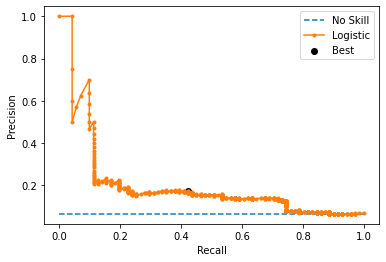

target: 5 actual target=1 ratio: 0.07
target: 5 predicted as target=1 ratio wrt best ROC thold: 0.35
target: 5 predicted as target=1 ratio wrt best F1 thold: 0.16
comparison of F1-scores: 0.245 0.245
Results of GCN11
Distribution of target (inequality): 6


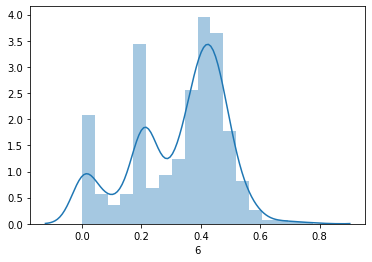

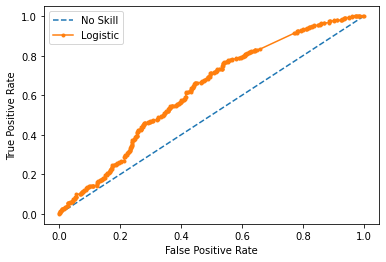

According to ROC Curve - Best Threshold=0.327530
According to precision recall curve: Best Threshold=0.327530, F-Score=0.488


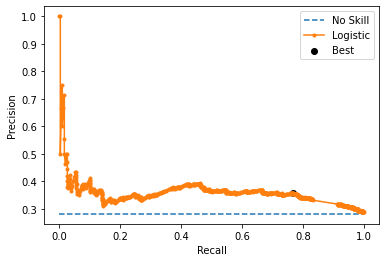

target: 6 actual target=1 ratio: 0.28
target: 6 predicted as target=1 ratio wrt best ROC thold: 0.6
target: 6 predicted as target=1 ratio wrt best F1 thold: 0.6
comparison of F1-scores: 0.488 0.488
Results of GAT11
Distribution of target (inequality): 6


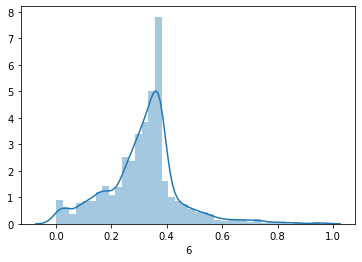

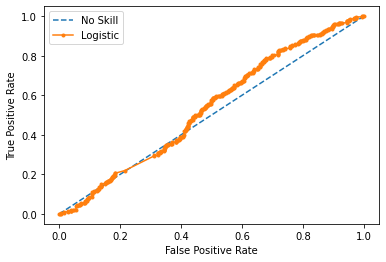

According to ROC Curve - Best Threshold=0.265013
According to precision recall curve: Best Threshold=0.818654, F-Score=nan


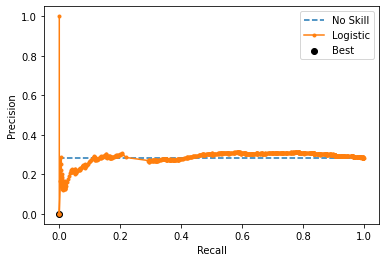

target: 6 actual target=1 ratio: 0.28
target: 6 predicted as target=1 ratio wrt best ROC thold: 0.71
target: 6 predicted as target=1 ratio wrt best F1 thold: 0.0
comparison of F1-scores: nan 0.0
Results of GCN11
Distribution of target (inequality): 7


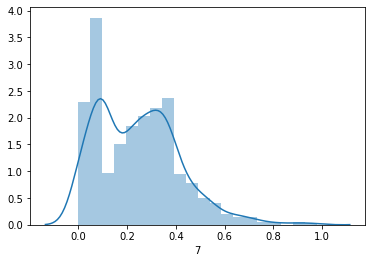

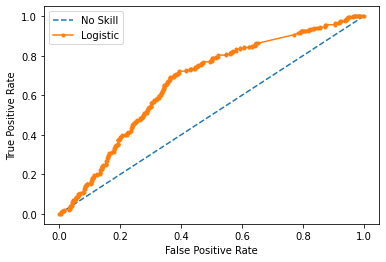

According to ROC Curve - Best Threshold=0.253929
According to precision recall curve: Best Threshold=0.887422, F-Score=nan


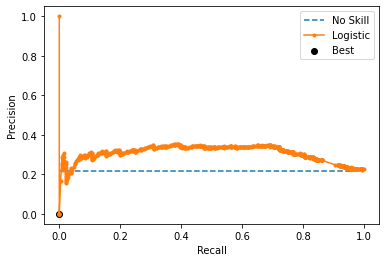

target: 7 actual target=1 ratio: 0.22
target: 7 predicted as target=1 ratio wrt best ROC thold: 0.46
target: 7 predicted as target=1 ratio wrt best F1 thold: 0.0
comparison of F1-scores: nan 0.0
Results of GAT11
Distribution of target (inequality): 7


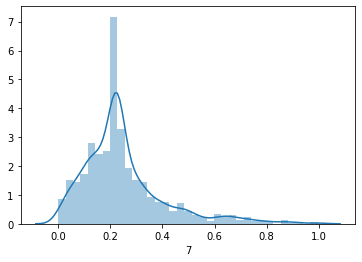

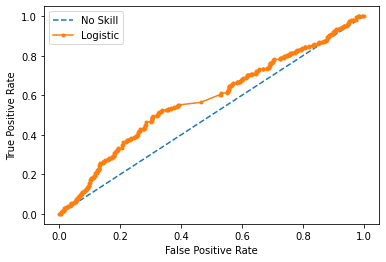

According to ROC Curve - Best Threshold=0.241138
According to precision recall curve: Best Threshold=0.917412, F-Score=nan


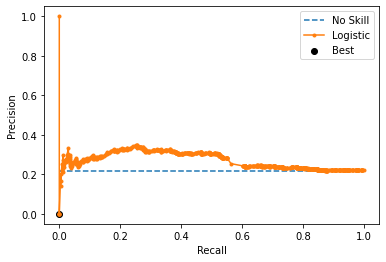

target: 7 actual target=1 ratio: 0.22
target: 7 predicted as target=1 ratio wrt best ROC thold: 0.37
target: 7 predicted as target=1 ratio wrt best F1 thold: 0.0
comparison of F1-scores: nan 0.0


In [ ]:
print("Performance on test graphs 2")
for k in range(len(weights)):
    pred1 = PRED11[k] # GCN mean tanh
    pred2 = PRED22[k] # GCN mean sigmoid

    label = test_labels[str(k)] # TRUE LABEL

    print("Results of GCN11")
    obj1 = perfo(pred1, k, label, 'GCN11_NEG')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj1, index=[0]))
    #print("Results of GCN22")
    #obj2 = perfo(pred2, k, label, 'GCN22')
    #picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj2, index=[0]))
    print("Results of GAT11")
    obj2 = perfo(pred2, k, label, 'GAT11_NEG')
    picked_tholds_test = picked_tholds_test.append(pd.DataFrame(obj2, index=[0]))

In [ ]:
# download performance metrics
picked_tholds_test.to_csv('picked_thold_test_neg.csv')
files.download('picked_thold_test_neg.csv') 